# The problem

In this experiment we assume that the observed data is generated by the process whose dynamics on the $(0,1)^2$ domain is given by
$$
-\Delta u = f,
$$
where 
$$
f(x, y) = 10 + 5(\sin(2\pi x) + \sin(2\pi y)),
$$
and $u(x, y) = 1$ when $x=1$ or $y=1$.

For our model, we assume the same dynamics but with the forcing function now defined as 
$$
f(x, y) = 10.
$$

We compute the prior solution using our assumed model before we observed the data, which are generated by the true process, plus the measurement noise.

Subsequently, we combine the prior solution with the observations to estimate various parameters and compute the posterior estimates for the solution. The parameters that are estimated are: misspecification magnitude ($\sigma_k$), misspecification lengthscale ($\ell_k$), and the scaling term ($\rho$).

Import the libraries

In [96]:
import numpy as np
from firedrake import UnitSquareMesh, FunctionSpace, TrialFunction, TestFunction
from firedrake import SpatialCoordinate, dx, pi, sin, dot, grad, DirichletBC, Constant
from firedrake import assemble, Function, solve
from firedrake import norms

import stat_fem
import matplotlib.pyplot as plt

import os
from pathlib import Path
fig_path = Path.home() / 'Dropbox' / 'phd' / 'projects' / 'stat-fem' / 'meeting-notes' / '2020-04-20-images'

Make the mesh and necessary Firedrake objects to express the problem in the variational form. The mesh is 100 points by 100 points.

In [165]:
nx = 101

mesh = UnitSquareMesh(nx - 1, nx - 1)
V = FunctionSpace(mesh, "CG", 1)

# The true process

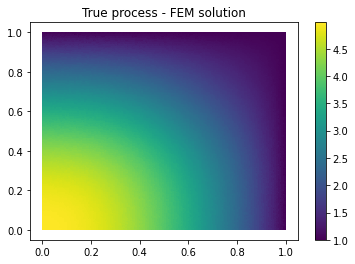

In [166]:
true_u = TrialFunction(V)
v = TestFunction(V)

true_f = Function(V)
x = SpatialCoordinate(mesh)
true_f.interpolate(10 + 5 * (sin(2 * pi * x[0]) + sin(2 * pi * x[1])))

true_a = (dot(grad(v), grad(true_u))) * dx
true_L = true_f * v * dx

# bc = DirichletBC(V, 0., "on_boundary")
bc = [DirichletBC(V, 1, 2), DirichletBC(V, 1, 4)]
true_A = assemble(true_a, bcs=bc)

true_b = assemble(true_L)

true_u = Function(V)

solve(true_A, true_u, true_b) # firedrake solve

plt.tripcolor(mesh.coordinates.vector().dat.data[:, 0],
              mesh.coordinates.vector().dat.data[:, 1],
              true_u.vector().dat.data)
plt.colorbar()
plt.title("True process - FEM solution")
plt.savefig(fig_path / 'true-process.png')

Define observation locations (a grid)

# Make observations using the true process

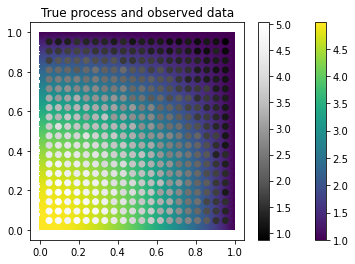

In [167]:
sigma_y = 0.1 # the nugget (measurement noise)

datagrid = 20
ndata = datagrid**2 
x_data = np.zeros((ndata , 2))

count = 0
for i in range(datagrid):
    for j in range(datagrid):
        x_data[count, 0] = float(i + 1) / float(datagrid + 1)
        x_data[count, 1] = float(j + 1) / float(datagrid + 1)
        count += 1
        
        
interp_matrix = stat_fem.InterpolationMatrix.InterpolationMatrix(V, x_data)
y = interp_matrix.interp_mesh_to_data(true_u.vector()) + np.random.normal(scale=sigma_y, size=ndata)

plt.tripcolor(mesh.coordinates.vector().dat.data[:, 0],
              mesh.coordinates.vector().dat.data[:, 1],
              true_u.vector().dat.data)
plt.colorbar()
plt.scatter(x_data[:, 0], x_data[:, 1], c=y, cmap="Greys_r")
plt.colorbar()
plt.title("True process and observed data")
plt.savefig(fig_path / 'true-process-with-one-observation.png')

# The prior FEM solution

We use Firedrake to solve for $u_h$ and plot the solution.

In [168]:
u = TrialFunction(V)
v = TestFunction(V)

f = Function(V)
x = SpatialCoordinate(mesh)
f.interpolate(Constant(10))

a = (dot(grad(v), grad(u))) * dx
L = f * v * dx

# bc = DirichletBC(V, 0., "on_boundary")
bc = [DirichletBC(V, 1, 2), DirichletBC(V, 1, 4)]
A = assemble(a, bcs=bc)

b = assemble(L)

u = Function(V)

solve(A, u, b) # firedrake solve

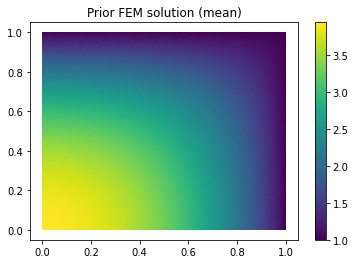

In [169]:
plt.tripcolor(mesh.coordinates.vector().dat.data[:, 0],
              mesh.coordinates.vector().dat.data[:, 1],
              u.vector().dat.data)
plt.colorbar()
plt.title("Prior FEM solution (mean)")
plt.savefig(fig_path / 'prior-mean.png')

# Estimate the parameters

We estimate $\rho$, $\sigma_k$, and $\ell_k$. We assume that the measurement noise is known.

In [170]:
log_sigma_f = np.log(2)
log_l_f = np.log(0.15)

G = stat_fem.ForcingCovariance(V, log_sigma_f, log_l_f, cutoff=1.e-3)
G.assemble()

Max nonzero elements in a row: 8889


In [171]:
obs_data = stat_fem.ObsData(x_data, y, sigma_y)
ls = stat_fem.estimate_params_MAP(A, b, G, obs_data)

In [172]:
print(f"MAP estimates on log-scale (ρ, σ_k, l_k): {np.exp(ls.params)}")

MAP estimates on log-scale (ρ, σ_k, l_k): [1.1023877  0.16837864 0.36608224]


# Posterior estimates

## Posterior mean of $u_h$

Below is the plot of the posterior mean of $u_h$ in the mesh space.

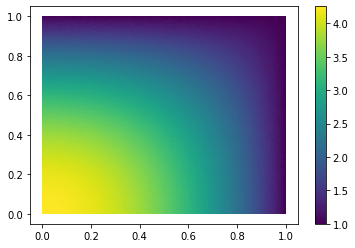

In [173]:
muy = Function(V)
ls.solve_posterior(muy)

plt.tripcolor(mesh.coordinates.vector().dat.data[:, 0],
              mesh.coordinates.vector().dat.data[:, 1],
              muy.vector().dat.data)
plt.colorbar()
plt.savefig(fig_path / 'posterior-mean-one-obs.png')

### Absolute difference between the posterior mean of $u_h$ and the prior mean.

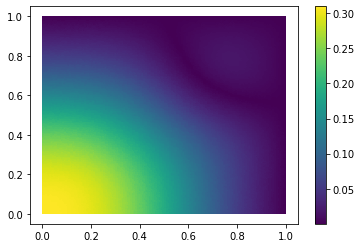

In [174]:
plt.tripcolor(mesh.coordinates.vector().dat.data[:, 0],
              mesh.coordinates.vector().dat.data[:, 1],
              np.abs(muy.vector().dat.data - u.vector().dat.data))
plt.colorbar()

## Comparison along the diagonal

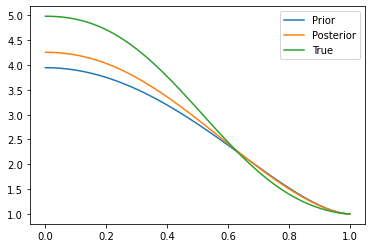

In [175]:
posterior_func_values = muy.vector().dat.data
prior_func_values = u.vector().dat.data
true_func_values = true_u.vector().dat.data
mesh_coords = mesh.coordinates.vector().dat.data

selected_coords = mesh_coords[mesh_coords[:, 0] == mesh_coords[:, 1]] 
selected_vals_posterior = posterior_func_values[mesh_coords[:, 0] == mesh_coords[:, 1]]
selected_vals_prior = prior_func_values[mesh_coords[:, 0] == mesh_coords[:, 1]]
selected_vals_true = true_func_values[mesh_coords[:, 0] == mesh_coords[:, 1]]

plt.plot(selected_coords[:, 0], selected_vals_prior)
plt.plot(selected_coords[:, 0], selected_vals_posterior)
plt.plot(selected_coords[:, 0], selected_vals_true)
plt.legend(['Prior', 'Posterior', 'True'])

## Marginal variance at grid locations before and after taking measurements

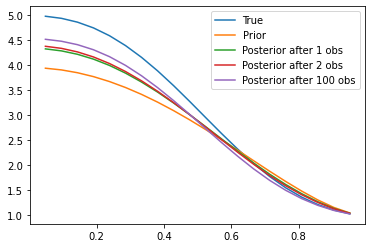

In [176]:
ls.data = obs_data
prior_mu_d, prior_Cu_d = ls.solve_prior()
post_mu_d, post_Cu_d = ls.solve_posterior_covariance()

selected_coords = x_data[x_data[:, 0] == x_data[:, 1]]

# True process
true_process = interp_matrix.interp_mesh_to_data(true_u.vector())[x_data[:, 0] == x_data[:, 1]]

# Prior solution
plt.plot(selected_coords[:, 0], true_process)

temp = prior_mu_d[x_data[:, 0] == x_data[:, 1]]
plt.plot(selected_coords[:, 0], temp)
error = prior_Cu_d[x_data[:, 0] == x_data[:, 1], x_data[:, 0] == x_data[:, 1]]


n_obs = 100
plot_snapshots = [1, 2, 100]
for i in range(n_obs):
    ls.mu = post_mu_d
    ls.Cu = post_Cu_d
    ls.data = stat_fem.ObsData(x_data,
                               interp_matrix.interp_mesh_to_data(true_u.vector()) + np.random.normal(scale=sigma_y, size=ndata), 
                               sigma_y)

    post_mu_d, post_Cu_d = ls.solve_posterior_covariance()
    
    if (i + 1) in plot_snapshots:
        temp = post_mu_d[x_data[:, 0] == x_data[:, 1]]
        plt.plot(selected_coords[:, 0], temp)
        error = post_Cu_d[x_data[:, 0] == x_data[:, 1], x_data[:, 0] == x_data[:, 1]]

plt.legend(['True', 'Prior'] + [f'Posterior after {n_obs} obs' for n_obs in plot_snapshots])

plt.savefig(fig_path / 'posterior-u-unscaled-contraction.png')

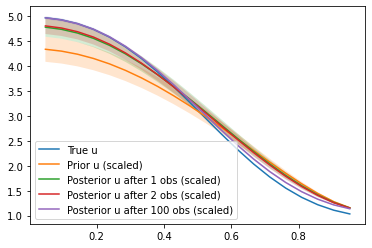

In [178]:
ls.data = obs_data
prior_mu_d, prior_Cu_d = ls.solve_prior()
post_mu_d, post_Cu_d = ls.solve_posterior_covariance()

selected_coords = x_data[x_data[:, 0] == x_data[:, 1]]

# True process
true_process = interp_matrix.interp_mesh_to_data(true_u.vector())[x_data[:, 0] == x_data[:, 1]]

# Prior solution
plt.plot(selected_coords[:, 0], true_process)
plt.fill_between(selected_coords[:, 0], true_process-0, true_process+0, alpha=0.2)

temp = np.exp(ls.params[0]) * prior_mu_d[x_data[:, 0] == x_data[:, 1]]
plt.plot(selected_coords[:, 0], temp)
error = prior_Cu_d[x_data[:, 0] == x_data[:, 1], x_data[:, 0] == x_data[:, 1]]
plt.fill_between(selected_coords[:, 0], temp-np.sqrt(error), temp+np.sqrt(error), alpha=0.2)


n_obs = 100
plot_snapshots = [1, 2, 100]
for i in range(n_obs):
    ls.mu = post_mu_d
    ls.Cu = post_Cu_d
    ls.data = stat_fem.ObsData(x_data,
                               interp_matrix.interp_mesh_to_data(true_u.vector()) + np.random.normal(scale=sigma_y, size=ndata), 
                               sigma_y)

    post_mu_d, post_Cu_d = ls.solve_posterior_covariance()
    
    if (i + 1) in plot_snapshots:
        temp = np.exp(ls.params[0]) * post_mu_d[x_data[:, 0] == x_data[:, 1]]
        plt.plot(selected_coords[:, 0], temp)
        error = post_Cu_d[x_data[:, 0] == x_data[:, 1], x_data[:, 0] == x_data[:, 1]]
        plt.fill_between(selected_coords[:, 0], temp-2*np.sqrt(error), temp+2*np.sqrt(error), alpha=0.2)

plt.legend(['True u', 'Prior u (scaled)'] + [f'Posterior u after {n_obs} obs (scaled)' for n_obs in plot_snapshots])
plt.savefig(fig_path / 'posterior-u-scaled-contraction.png')